In [3]:
import joblib
import pandas as pd
model_pipeline = joblib.load("../../data/model_pipeline.joblib")
train_path = "../../data/data_test.csv" 
df = pd.read_csv(train_path, sep=",", decimal=".")

# Scheiden van target en input variabelen
target = "Churn"

X = df.drop(columns=[target])
y = df[target]

X.shape, y.shape

((855, 9), (855,))

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from IPython.display import Markdown, display, Latex

def latex_cr(cr):
    c0 = cr['0']
    c1 = cr['1']
    macro = cr['macro avg']
    weighted = cr['weighted avg']
    acc = cr['accuracy']

    output = rf"""
$$
\begin{{array}}{{lrrrr}}
\text{{}} & \text{{Precision}} & \text{{Recall}} & \text{{F1-score}} & \text{{Support}} \\\hline
0 & {c0['precision']:.2f} & {c0['recall']:.2f} & {c0['f1-score']:.2f} & {c0['support']:.0f} \\
1 & {c1['precision']:.2f} & {c1['recall']:.2f} & {c1['f1-score']:.2f} & {c1['support']:.0f} \\\hline
\text{{accuracy}} & & & {acc:.2f} & \\
\text{{macro avg}} & {macro['precision']:.2f} & {macro['recall']:.2f} & {macro['f1-score']:.2f} & {macro['support']:.0f} \\
\text{{weighted avg}} & {weighted['precision']:.2f} & {weighted['recall']:.2f} & {weighted['f1-score']:.2f} & {weighted['support']:.0f}
\end{{array}}
$$
"""
    return Latex(output)




y_pred = model_pipeline.predict(X)

print("Accuracy:", accuracy_score(y, y_pred))
print("\nClassification report:\n", classification_report(y, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y, y_pred))
display(latex_cr(classification_report(y, y_pred,  zero_division=True, output_dict=True)))

Accuracy: 0.9122807017543859

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.88      0.44      0.59       121

    accuracy                           0.91       855
   macro avg       0.90      0.71      0.77       855
weighted avg       0.91      0.91      0.90       855


Confusion matrix:
 [[727   7]
 [ 68  53]]


<IPython.core.display.Latex object>

,precision,recall,f1-score,support
0,0.910000,0.990000,0.950000,734.000000
1,0.880000,0.440000,0.590000,121.000000
accuracy,0.910000,0.910000,0.910000,0.910000
macro avg,0.900000,0.710000,0.770000,855.000000
weighted avg,0.910000,0.910000,0.900000,855.000000


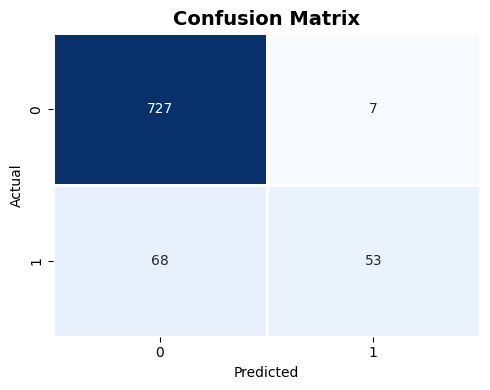

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import display, HTML

# Metrics berekenen
acc = accuracy_score(y, y_pred)
cr = classification_report(y, y_pred, output_dict=True)
df = pd.DataFrame(cr).T.round(2)
cm = confusion_matrix(y, y_pred)

# ======================
# 1️⃣ KPI BOVENAAN
# ======================
display(HTML(f"""
<div style="
    background-color:#111827;
    padding:25px;
    border-radius:12px;
    color:white;
    width:300px;
    text-align:center;
    font-family:Arial;">
    <div style="font-size:14px; opacity:0.7;">Accuracy</div>
    <div style="font-size:40px; font-weight:bold;">{acc:.2%}</div>
</div>
"""))

# ======================
# 2️⃣ STRAKKE TABEL
# ======================
def highlight_summary(row):
    if row.name in ["accuracy", "macro avg", "weighted avg"]:
        return ["background-color: #f3f4f6; font-weight: bold"] * len(row)
    return [""] * len(row)

styled = (
    df.style
      .apply(highlight_summary, axis=1)
      .set_properties(**{
          "text-align": "center",
          "font-size": "11pt"
      })
      .set_table_styles([
          {"selector": "th",
           "props": [("text-align", "center"),
                     ("font-weight", "bold"),
                     ("background-color", "#1f2937"),
                     ("color", "white")]}
      ])
)

display(styled)

# ======================
# 3️⃣ CONFUSION MATRIX
# ======================
plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            linewidths=1,
            linecolor='white')

plt.title("Confusion Matrix", fontsize=14, fontweight="bold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [51]:
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y, y_pred)

tn, fp, fn, tp = cm.ravel()

display(HTML(f"""
<div style="
    background-color:#111827;
    padding:25px;
    border-radius:12px;
    color:white;
    width:420px;
    font-family:Arial;
    margin-top:20px;
">
    <div style="font-size:18px; font-weight:bold; margin-bottom:15px;">
        Confusion Matrix
    </div>
    
    <div style="display:grid; grid-template-columns:1fr 1fr; gap:10px;">
        
        <div style="background:#1f2937; padding:20px; border-radius:8px; text-align:center;">
            <div style="font-size:12px; opacity:0.7;">True Negative</div>
            <div style="font-size:28px; font-weight:bold;">{tn}</div>
        </div>
        
        <div style="background:#7f1d1d; padding:20px; border-radius:8px; text-align:center;">
            <div style="font-size:12px; opacity:0.7;">False Positive</div>
            <div style="font-size:28px; font-weight:bold;">{fp}</div>
        </div>
        
        <div style="background:#7f1d1d; padding:20px; border-radius:8px; text-align:center;">
            <div style="font-size:12px; opacity:0.7;">False Negative</div>
            <div style="font-size:28px; font-weight:bold;">{fn}</div>
        </div>
        
        <div style="background:#065f46; padding:20px; border-radius:8px; text-align:center;">
            <div style="font-size:12px; opacity:0.7;">True Positive</div>
            <div style="font-size:28px; font-weight:bold;">{tp}</div>
        </div>
        
    </div>
</div>
"""))


In [339]:
from sklearn.metrics import classification_report, accuracy_score
from IPython.display import display, HTML


def display_classification_report(y_true, y_pred, max_width=500):
    # Bereken accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # Haal classification report op als dict
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Macro & weighted averages
    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1 = report['macro avg']['f1-score']
    
    weighted_precision = report['weighted avg']['precision']
    weighted_recall = report['weighted avg']['recall']
    weighted_f1 = report['weighted avg']['f1-score']
    
    # Class-specifiek (ervan uitgaande dat je classes 0 en 1 hebt)
    c0 = report['0']
    c1 = report['1']
    
    # HTML weergeven
    html = f"""
    <div style="font-family:Arial; max-width:{max_width}px; background:#1f2937; padding:20px; border-radius:12px; color:white; margin:left;">


        <!-- Dashboard Titel -->
        <div style="font-size:20px; font-weight:bold; margin-bottom:20px; text-align:center;">
            Classificatie Rapport
        </div>

        <!-- Accuracy -->
        <div style="background:#111827; padding:15px; border-radius:12px; width:150px; text-align:center; margin:auto; margin-bottom:20px;">
            <div style="font-size:12px; opacity:0.7;">Accuracy</div>
            <div style="font-size:28px; font-weight:bold;">{acc:.2%}</div>
        </div>

        <!-- Macro & Weighted Averages -->
        <div style="display:flex; gap:10px; margin-bottom:15px; flex-wrap: wrap; justify-content:center;">

            <!-- Macro -->
            <div style="background:#111827; padding:12px; border-radius:12px; width:150px; text-align:center;">
                <div style="font-size:12px; font-weight:bold; opacity:0.9; border-bottom:1px solid #374151; padding-bottom:5px; margin-bottom:10px;">
                    Macro
                </div>
                <div style="font-size:12px; opacity:0.7;">Precision</div>
                <div style="font-size:20px; font-weight:bold;">{macro_precision:.2f}</div>
                <div style="font-size:12px; opacity:0.7;">Recall</div>
                <div style="font-size:20px; font-weight:bold;">{macro_recall:.2f}</div>
                <div style="font-size:12px; opacity:0.7;">F1-score</div>
                <div style="font-size:20px; font-weight:bold;">{macro_f1:.2f}</div>
            </div>

            <!-- Weighted -->
            <div style="background:#111827; padding:12px; border-radius:12px; width:150px; text-align:center;">
                <div style="font-size:12px; font-weight:bold; opacity:0.9; border-bottom:1px solid #374151; padding-bottom:5px; margin-bottom:10px;">
                    Weighted
                </div>
                <div style="font-size:12px; opacity:0.7;">Precision</div>
                <div style="font-size:20px; font-weight:bold;">{weighted_precision:.2f}</div>
                <div style="font-size:12px; opacity:0.7;">Recall</div>
                <div style="font-size:20px; font-weight:bold;">{weighted_recall:.2f}</div>
                <div style="font-size:12px; opacity:0.7;">F1-score</div>
                <div style="font-size:20px; font-weight:bold;">{weighted_f1:.2f}</div>
            </div>

        </div>

        <!-- Class Metrics -->
        <div style="display:flex; gap:10px; flex-wrap: wrap; justify-content:center;">
            <!-- Class 0 -->
            <div style="background:#111827; padding:12px; border-radius:12px; width:140px; text-align:center;">
                <div style="font-size:12px; font-weight:bold; opacity:0.9; border-bottom:1px solid #374151; padding-bottom:5px; margin-bottom:10px;">
                    Class 0
                </div>
                <div style="display:flex; justify-content:space-between; margin-top:10px;">
                    <div style="text-align:center;">
                        <div style="font-size:12px; opacity:0.7;">P</div>
                        <div style="font-size:18px; font-weight:bold;">{c0['precision']:.2f}</div>
                    </div>
                    <div style="text-align:center;">
                        <div style="font-size:12px; opacity:0.7;">R</div>
                        <div style="font-size:18px; font-weight:bold;">{c0['recall']:.2f}</div>
                    </div>
                    <div style="text-align:center;">
                        <div style="font-size:12px; opacity:0.7;">F1</div>
                        <div style="font-size:18px; font-weight:bold;">{c0['f1-score']:.2f}</div>
                    </div>
                </div>
                <div style="margin-top:10px; font-size:12px; opacity:0.7;">Support: <b>{int(c0['support'])}</b></div>
            </div>

            <!-- Class 1 -->
            <div style="background:#111827; padding:12px; border-radius:12px; width:140px; text-align:center;">
                <div style="font-size:12px; font-weight:bold; opacity:0.9; border-bottom:1px solid #374151; padding-bottom:5px; margin-bottom:10px;">
                    Class 1
                </div>
                <div style="display:flex; justify-content:space-between; margin-top:10px;">
                    <div style="text-align:center;">
                        <div style="font-size:12px; opacity:0.7;">P</div>
                        <div style="font-size:18px; font-weight:bold;">{c1['precision']:.2f}</div>
                    </div>
                    <div style="text-align:center;">
                        <div style="font-size:12px; opacity:0.7;">R</div>
                        <div style="font-size:18px; font-weight:bold;">{c1['recall']:.2f}</div>
                    </div>
                    <div style="text-align:center;">
                        <div style="font-size:12px; opacity:0.7;">F1</div>
                        <div style="font-size:18px; font-weight:bold;">{c1['f1-score']:.2f}</div>
                    </div>
                </div>
                <div style="margin-top:10px; font-size:12px; opacity:0.7;">Support: <b>{int(c1['support'])}</b></div>
            </div>
        </div>

    </div>
    """
    display(HTML(html))


Class,Precision ⓘ,Recall ⓘ,F1-score ⓘ,Support ⓘ
Niet Opgezegd,0.91,0.99,0.95,734
Opgezegd,0.88,0.44,0.59,121


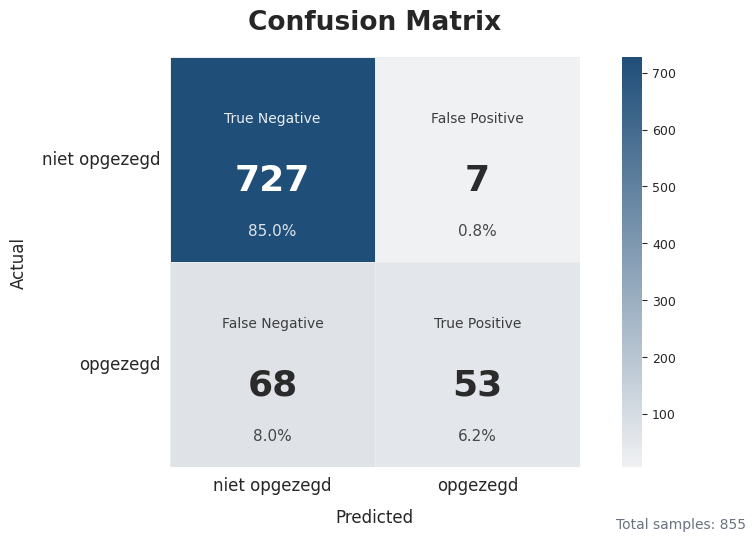

In [71]:
class_names = ["Niet Opgezegd", "Opgezegd"]
display_classification_report_boardroom(y, y_pred, class_names=class_names)
classes = ["niet opgezegd", "opgezegd"]
plot_confusion_matrix(y, y_pred, classes)

In [73]:
from sklearn.metrics import classification_report, accuracy_score
from IPython.display import display, HTML

def display_classification_report_boardroom(y_true, y_pred, class_names=None, max_width=900):

    unique_labels = sorted(list(set(y_true)))

    if class_names:
        if len(class_names) != len(unique_labels):
            raise ValueError("class_names moet dezelfde lengte hebben als unieke labels.")
        label_map = dict(zip(unique_labels, class_names))
        y_true = [label_map[y] for y in y_true]
        y_pred = [label_map[y] for y in y_pred]
        used_labels = class_names
    else:
        used_labels = [str(l) for l in unique_labels]

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    macro = report.get("macro avg", {})
    weighted = report.get("weighted avg", {})

    class_metrics = []
    for cls in used_labels:
        c = report.get(cls, {"precision":0,"recall":0,"f1-score":0,"support":0})
        class_metrics.append({
            "label": cls,
            "precision": c["precision"],
            "recall": c["recall"],
            "f1": c["f1-score"],
            "support": int(c["support"])
        })

    hover = {
        "accuracy": "Percentage correcte voorspellingen = juiste voorspellingen / totaal aantal observaties.",
        "macro": "Macro gemiddelde: gelijke weging per klasse, ongeacht grootte.",
        "weighted": "Weighted gemiddelde: gewogen naar aantal observaties per klasse.",
        "precision": "Precision = TP / (TP + FP) → Hoeveel van de voorspelde positieven waren correct.",
        "recall": "Recall = TP / (TP + FN) → Hoeveel van de werkelijke positieven zijn gevonden.",
        "f1": "F1-score = Harmonic mean van Precision en Recall.",
        "support": "Aantal observaties in deze klasse."
    }

    def info_icon(text):
        return f'<span style="font-size:12px; color:#6B7280; cursor:help; margin-left:4px;" title="{text}">ⓘ</span>'

    html = f"""
    <div style="
        font-family: 'Segoe UI', Arial, sans-serif;
        max-width:{max_width}px;
        padding:40px;
        background:white;
        color:#111827;
    ">

        <div style="font-size:26px; font-weight:600; margin-bottom:35px;">
            Model Performance Summary
        </div>

        <div style="display:flex; justify-content:space-between; margin-bottom:40px;">

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Accuracy {info_icon(hover["accuracy"])}
                </div>
                <div style="font-size:42px; font-weight:600; margin-top:4px;">
                    {acc:.2%}
                </div>
            </div>

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Macro Average {info_icon(hover["macro"])}
                </div>
                <div style="margin-top:6px; font-size:16px;">
                    Precision: <b>{macro.get("precision",0):.2f}</b><br>
                    Recall: <b>{macro.get("recall",0):.2f}</b><br>
                    F1-score: <b>{macro.get("f1-score",0):.2f}</b>
                </div>
            </div>

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Weighted Average {info_icon(hover["weighted"])}
                </div>
                <div style="margin-top:6px; font-size:16px;">
                    Precision: <b>{weighted.get("precision",0):.2f}</b><br>
                    Recall: <b>{weighted.get("recall",0):.2f}</b><br>
                    F1-score: <b>{weighted.get("f1-score",0):.2f}</b>
                </div>
            </div>

        </div>

        <div style="height:1px; background:#E5E7EB; margin-bottom:30px;"></div>

        <div style="font-size:18px; font-weight:600; margin-bottom:20px;">
            Per Class Performance
        </div>

        <table style="width:100%; border-collapse:collapse; font-size:15px;">
            <thead>
                <tr style="text-align:left; border-bottom:2px solid #111827;">
                    <th style="padding:10px 0;">Class</th>
                    <th>Precision {info_icon(hover["precision"])}</th>
                    <th>Recall {info_icon(hover["recall"])}</th>
                    <th>F1-score {info_icon(hover["f1"])}</th>
                    <th>Support {info_icon(hover["support"])}</th>
                </tr>
            </thead>
            <tbody>
    """

    for c in class_metrics:
        html += f"""
            <tr style="border-bottom:1px solid #E5E7EB;">
                <td style="padding:12px 0;">{c['label']}</td>
                <td>{c['precision']:.2f}</td>
                <td>{c['recall']:.2f}</td>
                <td>{c['f1']:.2f}</td>
                <td>{c['support']}</td>
            </tr>
        """

    html += """
            </tbody>
        </table>
    </div>
    """

    display(HTML(html))

class_names = ["Niet Opgezegd", "Opgezegd"]
display_classification_report_boardroom(y, y_pred, class_names=class_names)


Class,Precision ⓘ,Recall ⓘ,F1-score ⓘ,Support ⓘ
Niet Opgezegd,0.91,0.99,0.95,734
Opgezegd,0.88,0.44,0.59,121


Class,Precision ⓘ,Recall ⓘ,F1-score ⓘ,Support ⓘ
Niet Opgezegd,0.91,0.99,0.95,734
Opgezegd,0.88,0.44,0.59,121

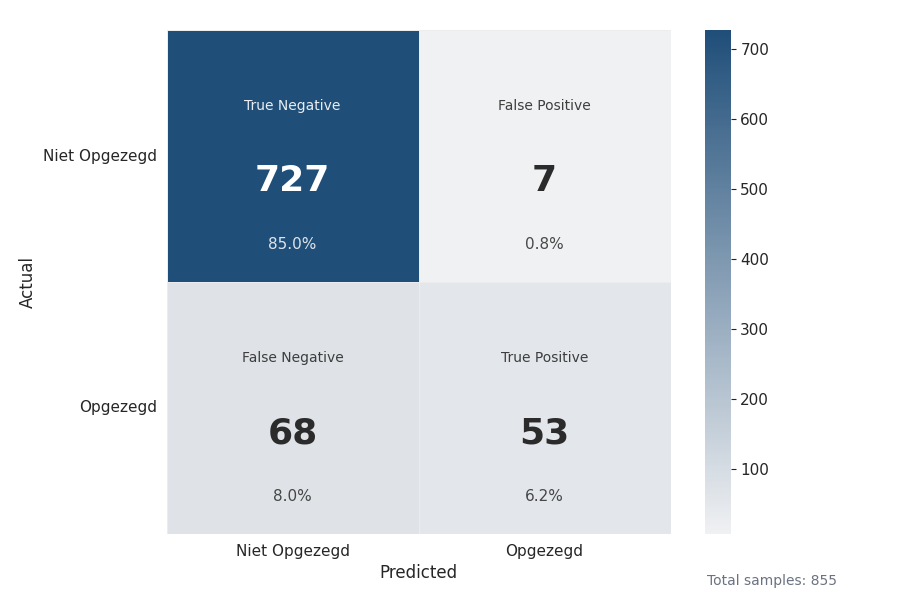

In [138]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from io import BytesIO
import base64

def display_executive_model_evaluation(y_true, y_pred, class_names=None):

    # -------------------------
    # Label mapping
    # -------------------------
    unique_labels = sorted(list(set(y_true)))

    if class_names:
        if len(class_names) != len(unique_labels):
            raise ValueError("class_names moet dezelfde lengte hebben als unieke labels.")
        label_map = dict(zip(unique_labels, class_names))
        y_true = [label_map[y] for y in y_true]
        y_pred = [label_map[y] for y in y_pred]
        used_labels = class_names
    else:
        used_labels = [str(l) for l in unique_labels]

    # -------------------------
    # Metrics
    # -------------------------
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    macro = report.get("macro avg", {})
    weighted = report.get("weighted avg", {})

    class_metrics = []
    for cls in used_labels:
        c = report.get(cls, {"precision":0,"recall":0,"f1-score":0,"support":0})
        class_metrics.append({
            "label": cls,
            "precision": c["precision"],
            "recall": c["recall"],
            "f1": c["f1-score"],
            "support": int(c["support"])
        })

    # -------------------------
    # Hover explanations
    # -------------------------
    hover = {
        "accuracy": "Percentage correcte voorspellingen = juiste voorspellingen / totaal aantal observaties.",
        "macro": "Macro gemiddelde: gelijke weging per klasse, ongeacht grootte.",
        "weighted": "Weighted gemiddelde: gewogen naar aantal observaties per klasse.",
        "precision": "Precision = TP / (TP + FP)",
        "recall": "Recall = TP / (TP + FN)",
        "f1": "F1-score = Harmonic mean van Precision en Recall.",
        "support": "Aantal observaties in deze klasse."
    }

    def info_icon(text):
        return f'<span style="font-size:12px; color:#9CA3AF; cursor:help; margin-left:4px;" title="{text}">ⓘ</span>'

    # -------------------------
    # HTML REPORT
    # -------------------------
    html = f"""
    <div style="
        font-family:'Segoe UI', Arial, sans-serif;
        max-width:1000px;
        padding:30px;
        color:#111827;
        background:#FFFFFF;
        border-radius:8px;
        box-shadow: 0 8px 20px rgba(0,0,0,0.1);  /* Extra premium schaduw */
    ">

        <div style="font-size:28px; font-weight:600; margin-bottom:35px;">
            Model Performance Summary
        </div>

        <div style="display:flex; gap:80px; margin-bottom:45px;">

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Accuracy {info_icon(hover["accuracy"])}
                </div>
                <div style="font-size:44px; font-weight:600; margin-top:4px;">
                    {acc:.2%}
                </div>
            </div>

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Macro Average {info_icon(hover["macro"])}
                </div>
                <div style="margin-top:6px; font-size:16px; line-height:1.6;">
                    Precision: <b>{macro.get("precision",0):.2f}</b><br>
                    Recall: <b>{macro.get("recall",0):.2f}</b><br>
                    F1-score: <b>{macro.get("f1-score",0):.2f}</b>
                </div>
            </div>

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Weighted Average {info_icon(hover["weighted"])}
                </div>
                <div style="margin-top:6px; font-size:16px; line-height:1.6;">
                    Precision: <b>{weighted.get("precision",0):.2f}</b><br>
                    Recall: <b>{weighted.get("recall",0):.2f}</b><br>
                    F1-score: <b>{weighted.get("f1-score",0):.2f}</b>
                </div>
            </div>

        </div>

        <div style="height:1px; background:#E5E7EB; margin-bottom:40px;"></div>

        <div style="font-size:20px; font-weight:600; margin-bottom:20px;">
            Per Class Performance
        </div>

        <table style="width:100%; border-collapse:collapse; font-size:15px;">
            <thead>
                <tr style="text-align:left; border-bottom:2px solid #111827;">
                    <th style="padding:12px 0;">Class</th>
                    <th>Precision {info_icon(hover["precision"])}</th>
                    <th>Recall {info_icon(hover["recall"])}</th>
                    <th>F1-score {info_icon(hover["f1"])}</th>
                    <th>Support {info_icon(hover["support"])}</th>
                </tr>
            </thead>
            <tbody>
    """

    for c in class_metrics:
        html += f"""
            <tr style="border-bottom:1px solid #E5E7EB;">
                <td style="padding:12px 0;">{c['label']}</td>
                <td><b>{c['precision']:.2f}</b></td>
                <td><b>{c['recall']:.2f}</b></td>
                <td><b>{c['f1']:.2f}</b></td>
                <td>{c['support']}</td>
            </tr>
        """

    html += """
            </tbody>
        </table>

        <div style="height:1px; background:#E5E7EB; margin:30px 0;"></div>

        <div style="font-size:20px; font-weight:600; margin-bottom:0px;">
            Confusion Matrix
        </div>

        <div id="confusion-matrix-container" style="width:100%; text-align:left; padding:0px 0;">
            <img src="data:image/png;base64,{confusion_matrix_img}" alt="Confusion Matrix" width="70%" />
        </div>

    </div>
    """

    # -------------------------
    # CONFUSION MATRIX
    # -------------------------
    # -------------------------
    # CONFUSION MATRIX
    # -------------------------
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    percent = cm / total * 100

    sns.set_style("white")
    plt.rcParams.update({"font.family": "DejaVu Sans"})

    fig, ax = plt.subplots(figsize=(9, 6))

    cmap = sns.light_palette("#1f4e79", as_cmap=True)

    heatmap = sns.heatmap(
        cm,
        annot=False,
        cmap=cmap,
        cbar=True,
        linewidths=0.6,
        linecolor="#ECECEC",
        square=True,
        ax=ax
    )

    threshold = cm.max() / 2

    labels_matrix = [["True Negative", "False Positive"],
                    ["False Negative", "True Positive"]]

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "#2b2b2b"

            ax.text(j + 0.5, i + 0.30,
                    labels_matrix[i][j],
                    ha='center', va='center',
                    fontsize=10,
                    color=color,
                    alpha=0.9)
            
            # Groot getal in het midden
            ax.text(j + 0.5, i + 0.60,
                    f"{cm[i,j]:,}",
                    ha='center', va='center',
                    fontsize=26,
                    fontweight='bold',
                    color=color)
            
            # Percentage onderin
            ax.text(j + 0.5, i + 0.85,
                    f"{percent[i,j]:.1f}%",
                    ha='center', va='center',
                    fontsize=11,
                    color=color,
                    alpha=0.85)

    fig.text(0.93, 0.02,
            f"Total samples: {total:,}",
            ha="right",
            va="bottom",
            fontsize=10,
            color="#6B7280")
    # Bovenkant van de afbeelding afsnijden (croppen)
    fig.subplots_adjust(top=0.95)  # Verkort de bovenkant (door de top margin in te stellen)


    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("Actual", fontsize=12)

    ax.set_xticklabels(used_labels)
    ax.set_yticklabels(used_labels, rotation=0)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Sla de plot op in geheugen
    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png')
    img_buffer.seek(0)

    # Zet het om naar base64
    confusion_matrix_img = base64.b64encode(img_buffer.read()).decode('utf-8')

    # Pas de HTML aan
    html = html.format(confusion_matrix_img=confusion_matrix_img)

    plt.close()

    # Display de volledige HTML
    display(HTML(html))


# Usage example:
class_names = ["Niet Opgezegd", "Opgezegd"]

display_executive_model_evaluation(
    y,
    y_pred,
    class_names=class_names
)


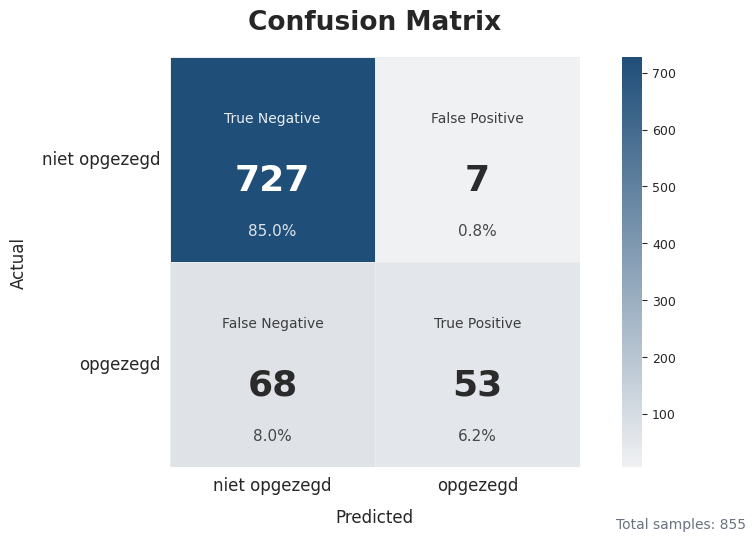

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes=None, title="Confusion Matrix"):
    """
    Plot een nette corporate-stijl confusion matrix met counts, percentages, en TP/TN labels.

    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    classes : list, optional
        Namen van de classes (volgorde moet overeenkomen met unieke labels)
    title : str
        Titel boven de matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    percent = cm / total * 100
    
    # Default classnames
    if classes is None:
        classes = [str(i) for i in range(len(cm))]

    pos_labels = [["True Negative", "False Positive"],
                  ["False Negative", "True Positive"]]

    # Corporate stijl
    sns.set_style("white")
    plt.rcParams.update({"font.family": "DejaVu Sans", "font.size": 11})
    
    fig, ax = plt.subplots(figsize=(9, 5.5))
    
    cmap = sns.light_palette("#1f4e79", as_cmap=True)
    
    heatmap = sns.heatmap(
        cm,
        annot=False,
        cmap=cmap,
        cbar=True,
        linewidths=0.6,
        linecolor="#ECECEC",
        square=True,
        ax=ax
    )
    
    threshold = cm.max() / 2
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "#2b2b2b"
            
            # TP/TN/FP/FN label boven
            ax.text(j + 0.5, i + 0.30,
                    pos_labels[i][j],
                    ha='center', va='center',
                    fontsize=10,
                    color=color,
                    alpha=0.9)
            
            # Groot getal in het midden
            ax.text(j + 0.5, i + 0.60,
                    f"{cm[i,j]:,}",
                    ha='center', va='center',
                    fontsize=26,
                    fontweight='bold',
                    color=color)
            
            # Percentage onderin
            ax.text(j + 0.5, i + 0.85,
                    f"{percent[i,j]:.1f}%",
                    ha='center', va='center',
                    fontsize=11,
                    color=color,
                    alpha=0.85)
    
    # Titel
    ax.set_title(title,
                 fontsize=19,
                 fontweight="semibold",
                 pad=20)
    
    # Totale samples rechtsonder
    fig.text(0.98, 0.02,
             f"Total samples: {total:,}",
             ha="right",
             va="bottom",
             fontsize=10,
             color="#6B7280")
    
    # As labels
    ax.set_xlabel("Predicted", fontsize=12, labelpad=10)
    ax.set_ylabel("Actual", fontsize=12, labelpad=10)
    
    ax.set_xticks(np.arange(len(classes)) + 0.5)
    ax.set_xticklabels(classes, fontsize=12)
    
    ax.set_yticks(np.arange(len(classes)) + 0.5)
    ax.set_yticklabels(classes, fontsize=12, rotation=0)
    
    # Colorbar styling
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    cbar.outline.set_visible(False)
    
    # Randen verwijderen
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.show()

classes = ["niet opgezegd", "opgezegd"]
plot_confusion_matrix(y, y_pred, classes)
